Este código genera los dataset de DB3, para las particiones de datos por sujeto y por repetición. Se incluye código de visualización para verificar el funcionamiento.

In [73]:
import numpy as np
import pickle
import joblib
import pandas as pd
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.impute import SimpleImputer
import os
import random
import matplotlib.cm as cm
import seaborn as sns
from sklearn.decomposition import PCA


# Definición de variables y funciones

- input_sequence_length: se elige que sea de 650 muestras (3.25s) considerando que cada gesto dura 5s.
- stride: se elige 5 ya que se vio que tomar más secuencias tiene un efecto positivo. 

In [34]:
# Rutas
ruta_datos = "../data/"    # defino ruta a los datos 
nombre_datos = 'data_gestos_puntuales_fs200_DB3.pickle'

# Conformación de datasets
input_sequence_length = 650     # largo de las secuencias en muestras
stride = 5      # stride de las secuencias
sup_gesto_secuencia = 1     # superposición gesto-secuencia de 100%. sólo considero las secuencias en las que hay gesto en todas las muestras

In [35]:
# función para unir datos de entrada, labels y vector de pesos
def combine_features_labels_weights(features, sample_weights):
    inputs, labels = features
    return inputs, labels, sample_weights

# función para identificar a qué repetición corresponde una secuencia
def find_most_similar_array_index(target_array, list_of_arrays):
  max_common_elements = 0
  most_similar_index = -1

  for index, array in enumerate(list_of_arrays):
      # Convert both arrays to sets
      target_set = set(target_array)
      array_set = set(array)

      # Find the number of common elements
      common_elements = len(target_set.intersection(array_set))

      # Update the most similar array index if this one has more common elements
      if common_elements > max_common_elements:
          max_common_elements = common_elements
          most_similar_index = index

  return most_similar_index

# Levanto los datos del Experimento 1

In [36]:
# Cargo los datos
os.chdir(ruta_datos) # me situo en el directorio
file = open(nombre_datos, 'rb') # abro el archivo
MyoArm_data = pickle.load(file) # guardo los datos en un data y cierro el archivo
file.close()

## Extracción de datos y corrección de etiquetas

In [52]:
# Extraigo los datos del dataframe
data = MyoArm_data['data']
label = MyoArm_data['label']
subject = MyoArm_data['subject']

nOfSubjects = np.max(subject)   # calculo la cantidad de sujetos

In [53]:
# TODO no hardcodear el mapeo
# Creo un diccionario de mapeo para los valores de etiqueta
mapeo = {0: 0, 5: 1, 6: 2, 7: 3, 9: 4, 10: 5, 13: 6, 14: 7, 22: 8, 26: 9, 31: 10}

# Hago el reemplazo de las etiquetas
label = np.vectorize(mapeo.get)(label)

In [54]:
# Observo cuantos datos tengo de cada etiqueta, viendo una gran cantidad de reposos, y una cantidad similar entre el resto de clases
values, counts = np.unique(label, return_counts=True)
print(values)   # imprimo valores de etiquetas
print(counts)   # imprimo la cantidad de datos de cada etiqueta

[ 0  1  2  3  4  5  6  7  8  9 10]
[1903645   69264   69408   69342   69415   68690   69347   69613   68545
   68807   63080]


In [55]:
# Si hay clases que no están, identificarlas
etiquetas_no_mapeadas = set(label) - set(mapeo.keys())
print("Etiquetas no mapeadas:", etiquetas_no_mapeadas)

Etiquetas no mapeadas: {np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(8)}


# Rellenado de datos

Relleno datos faltantes según una distribución normal de media y desviación estándar igual a la de los datos del reposo.

In [56]:
def aplicar_imputer(data, label):
  # calculo desviacion estandar sobre los datos de reposo
  ind_reposo = np.where(label==0)[0]

  std_reposo = np.nanstd(data[ind_reposo], axis=0)
  mean_reposo = np.nanmean(data[ind_reposo], axis=0)

  # relleno manualmente los NaN en cada columna con los valores de relleno
  for i in range(data.shape[1]):
      nan_mask = np.isnan(data[:, i])  # máscara de los NaN en la columna i
      data[nan_mask, i] = std_reposo[i]*np.random.normal() + mean_reposo[i]  # reemplazo los NaN por el valor de relleno correspondiente

  return data

data = aplicar_imputer(data, label)

# Para termianr, chequeo si hay alguna etiqueta nan
nan_indices = np.isnan(data)
np.where(nan_indices==True)

(array([], dtype=int64), array([], dtype=int64))

In [57]:
# hago una lista de dataframes, donde cada elemento tiene los datos asociados a los distintos sujetos 
list_data_x_sujeto = []
list_label_x_sujeto = []

for i in range(1, nOfSubjects+1):
  ind_sujeto_act = np.where(subject==i)[0]
  list_data_x_sujeto.append(data[ind_sujeto_act])
  list_label_x_sujeto.append(label[ind_sujeto_act])

# Enfoques de visualización

d:\PFG_Molina\entorno_PFG_Molina\lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


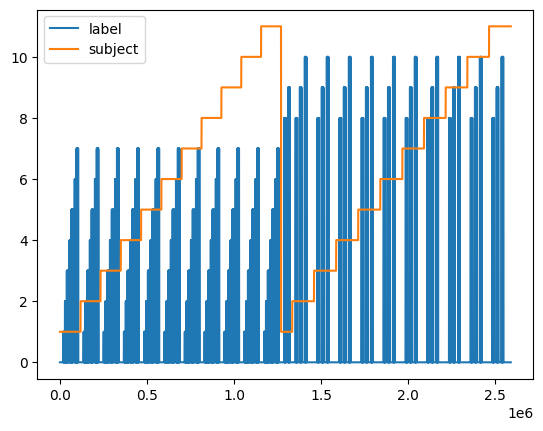

In [58]:
# plot de etiquetas y sujetos
plt.figure()
# plt.plot(data[:, 0])
plt.plot(label)
plt.plot(subject)
plt.legend(['label', 'subject'])

In [ ]:
# boxplots
# --- Preparar ---
n_channels = data.shape[1]
unique_subjects = np.unique(subject)
n_subjects = len(unique_subjects)

fig, axes = plt.subplots(n_subjects, 1, figsize=(15, 4 * n_subjects), sharex=True)

if n_subjects == 1:
    axes = [axes]  # asegurar que sea iterable

# --- Loop por sujeto ---
for i, subj in enumerate(unique_subjects):
    mask = subject == subj
    subj_data = data[mask, :]  # filas del sujeto i, todas las columnas

    # Boxplot de los 12 canales
    axes[i].boxplot([subj_data[:, ch] for ch in range(n_channels)])
    axes[i].set_title(f"Sujeto: {subj}")
    axes[i].set_ylabel("Valor")
    axes[i].grid(True)
    axes[i].set_xticks(range(1, n_channels + 1))
    axes[i].set_xticklabels([f"Ch{ch+1}" for ch in range(n_channels)])

axes[-1].set_xlabel("Canales")
plt.tight_layout()
plt.show()

In [ ]:
#TODO esto es mejor hacerlo antes de aplicar el imputer
subjects_unique = np.unique(subject)
n_subjects = len(subjects_unique)
n_channels = data.shape[1]

# Calcular la desviación estándar por sujeto y canal
stds = np.zeros((n_subjects, n_channels))

for i, subj in enumerate(subjects_unique):
    mask = subject == subj
    subj_data = data[mask, :]
    stds[i, :] = np.std(subj_data, axis=0)

# Graficar heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(stds, annot=False, cmap="coolwarm", xticklabels=[f"Ch{j+1}" for j in range(n_channels)], yticklabels=subjects_unique-1)
plt.title("Desviación estándar por sujeto y canal")
plt.xlabel("Canales")
plt.ylabel("Sujetos")
plt.show()

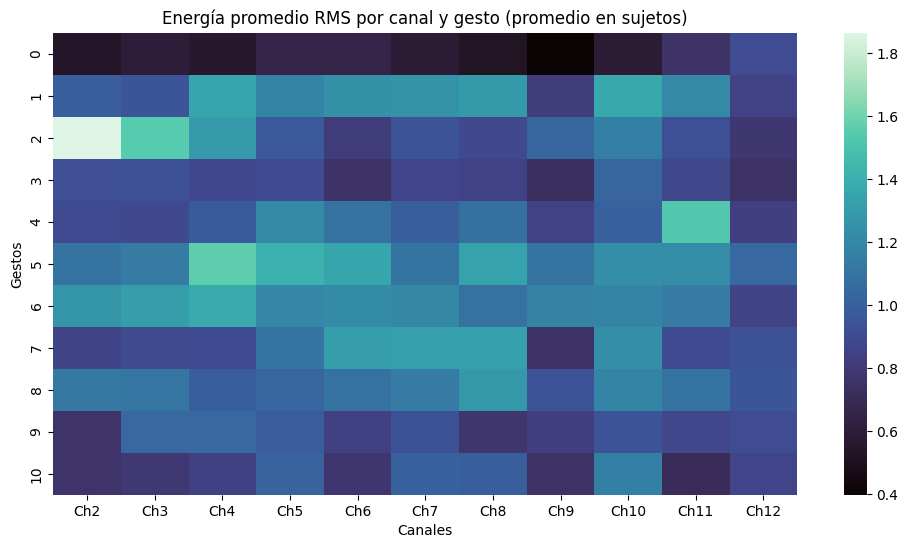

In [61]:
subjects_unique = np.unique(subject)
gestures_unique = np.unique(label)
n_channels = data.shape[1]

# Calcular energía RMS por canal, sujeto y gesto
stats = []
for subj in subjects_unique:
    for gest in gestures_unique:
        mask = (subject == subj) & (label == gest)
        if np.sum(mask) > 0:
            rms = np.sqrt(np.mean(data[mask]**2, axis=0))
            stats.append([subj, gest] + list(rms))

df_stats = pd.DataFrame(stats, columns=["subject", "gesture"] + [f"Ch{i+1}" for i in range(n_channels)])

# Heatmap promedio por gesto (por ejemplo)
plt.figure(figsize=(12,6))
sns.heatmap(df_stats.groupby("gesture").mean(numeric_only=True).iloc[:, 2:], cmap="mako", annot=False)
plt.title("Energía promedio RMS por canal y gesto (promedio en sujetos)")
plt.xlabel("Canales")
plt.ylabel("Gestos")
plt.show()


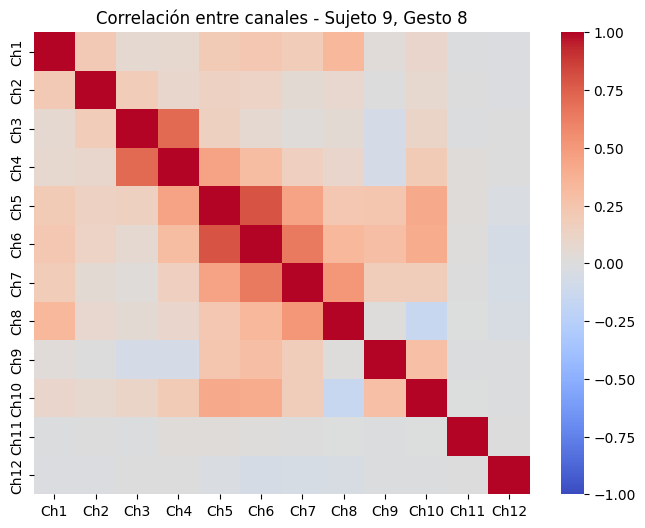

In [62]:
# correlacion entre canales. quiero correlacion entre diferentes canales, significa que responden
# de forma similar ante un estimulo entonces estoy detectando algo
# Elegir un sujeto o gesto
sujeto = subjects_unique[8]
gesto = gestures_unique[8]
mask = (subject == sujeto) & (label == gesto)
corr = np.corrcoef(data[mask].T)

plt.figure(figsize=(8,6))
sns.heatmap(corr, cmap="coolwarm", vmin=-1, vmax=1,
            xticklabels=[f"Ch{i+1}" for i in range(n_channels)],
            yticklabels=[f"Ch{i+1}" for i in range(n_channels)])
plt.title(f"Correlación entre canales - Sujeto {sujeto}, Gesto {gesto}")
plt.show()

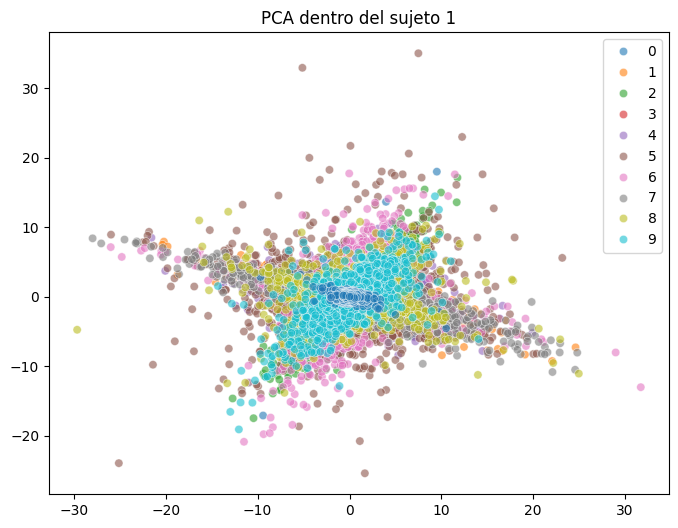

In [ ]:
subj = np.unique(subject)[0]  # probá con un sujeto específico
mask = subject == subj

pca = PCA(n_components=4)   # cantidad de componentes a utilizar
X_pca = pca.fit_transform(data[mask])

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1],   # componentes que quiero graficar
                hue=label[mask], palette='tab10', alpha=0.6)
plt.title(f"PCA dentro del sujeto {subj}")
plt.show()


In [ ]:
df = pd.DataFrame(data, columns=[f"Ch{i+1}" for i in range(n_channels)])
df["gesture"] = label

sns.violinplot(x="variable", y="value", hue="gesture",
               data=df.melt(id_vars="gesture"), split=True, inner="quartile")
plt.xticks(rotation=45)
plt.title("Distribución de amplitudes EMG por canal y gesto")
plt.show()


# Cálculo del vector de pesos
Hago una simulación de armar los datasets para ver cuántas secuencias queda de cada clase. No se tiene en cuenta el reposo, por que lo ahora la numeración de las clases se mueve un lugar a la izquierda: la que antes era la clase 1, ahora es la 0.

In [9]:
# TODO no hacer una simulación de armar los datasets, sino que hacerlo más derecho fijándome cuántas secuencias cumplen la condición de superposición gesto-secuencia
# para cada sujeto armo un Dataset con las secuencias de datos y etiquetas
list_labels_dataset_x_sujeto = []

for j in range(nOfSubjects):#
  label_j = list_label_x_sujeto[j]

  label_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=label_j,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # multiplo de 8
          sequence_stride = stride
        )

  secuencias_labels_list = []

  for x in label_dataset:
    secuencias_labels_list.append(x)

  selected_secuencias_labels_list = []

  contador_reposos = 0

  for i in range(len(secuencias_labels_list)):  # len(secuencias_labels_list)
    unique_values, counts = np.unique(secuencias_labels_list[i], return_counts=True)
    # Encontrar el valor que más se repite
    max_count_index = np.argmax(counts)
    most_frequent_value = unique_values[max_count_index]
    counts_most_frequent = counts[max_count_index]

    if most_frequent_value==0:
      contador_reposos += 1

    if (((counts_most_frequent/len(secuencias_labels_list[i])) == sup_gesto_secuencia) and (most_frequent_value != 0)):
      selected_secuencias_labels_list.append(most_frequent_value)

  list_labels_dataset_x_sujeto.extend(selected_secuencias_labels_list)
  
  unique_values, counts = np.unique(list_labels_dataset_x_sujeto, return_counts=True)
# Calcula los pesos de clase
class_weights = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(list_labels_dataset_x_sujeto), y=np.array(list_labels_dataset_x_sujeto))
# Convierte los pesos a un diccionario
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Pesos de clase:", class_weights_dict) 

joblib.dump(class_weights_dict, "pesos_x_clase.pkl")

Pesos de clase: {0: np.float64(0.9884702764104506), 1: np.float64(0.9814097744360902), 2: np.float64(0.9839992461364493), 3: np.float64(0.9830728676332141), 4: np.float64(1.0096886482305163), 5: np.float64(0.9839992461364493), 6: np.float64(0.9757241637077182), 7: np.float64(1.01498833592535), 8: np.float64(1.0048306389530408), 9: np.float64(1.0823175787728025)}


['pesos_x_clase.pkl']

# Partición de datos por sujeto

## Generación de datasets sin normalización


In [ ]:
# Accedo al vector de pesos
class_weights_dict = joblib.load("pesos_x_clase.pkl")

In [ ]:
for j in range(nOfSubjects):#
  label_j = list_label_x_sujeto[j]
  data_j = list_data_x_sujeto[j]

  label_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=label_j,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # potencia de 2
          sequence_stride = stride
        )
  data_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=data_j,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # potencia de 2
          sequence_stride = stride
        )

  secuencias_labels_list = []
  secuencias_data_list = []

  for x in label_dataset:
    secuencias_labels_list.append(x)

  for x in data_dataset:
    secuencias_data_list.append(x)

  selected_secuencias_labels_list = []
  selected_secuencias_data_list = []

  contador_reposos = 0

  for i in range(len(secuencias_labels_list)):
    unique_values, counts = np.unique(secuencias_labels_list[i], return_counts=True)
    # encuentro el valor que más se repite
    max_count_index = np.argmax(counts)
    most_frequent_value = unique_values[max_count_index]
    counts_most_frequent = counts[max_count_index]

    if most_frequent_value==0:
      contador_reposos += 1

    if (((counts_most_frequent/len(secuencias_labels_list[i])) == sup_gesto_secuencia) and (most_frequent_value != 0)): # la segunda condicion es para excluir el reposo
      selected_secuencias_labels_list.append(most_frequent_value)
      selected_secuencias_data_list.append(secuencias_data_list[i])

  selected_secuencias_labels_array = np.array(selected_secuencias_labels_list)

  # creo una matriz de pesos de la misma forma que y_train
  sample_weight = np.zeros(selected_secuencias_labels_array.shape)

  selected_secuencias_labels_array = selected_secuencias_labels_array - 1

  # asigno los pesos de clase a cada timestep en la secuencia
  for i, class_weight in class_weights_dict.items():
      sample_weight[selected_secuencias_labels_array == i] = class_weight

  # convierto las listas en tensores de TensorFlow
  tensores = tf.stack(selected_secuencias_data_list)
  etiquetas = tf.convert_to_tensor(list(selected_secuencias_labels_array))

  sample_weight_tensor = tf.convert_to_tensor(sample_weight, dtype=tf.float32)
  sample_weight_dataset = tf.data.Dataset.from_tensor_slices(sample_weight_tensor)

  # creo un dataset a partir de los tensores y etiquetas
  input_dataset = tf.data.Dataset.from_tensor_slices((tensores, etiquetas))
  # agrego el vector de pesos
  rnn_dataset_j = tf.data.Dataset.zip((input_dataset, sample_weight_dataset))
  rnn_dataset_j_def = rnn_dataset_j.map(combine_features_labels_weights)

  # guardo el dataset
  rnn_dataset_j_def.save("dataset_x_sujeto_"+str(input_sequence_length) + "_stride" + str(stride) + "_sub"+str(j))

# Partición de datos por repetición

## Cálculo y visualización de las repeticiones

In [11]:
# calculo cantidad de repeticiones de cada gesto
flancos = np.diff(label)  # con estos flancos puedo dividir las repeticiones
rep_starts_ind = np.where(flancos>0)[0]
rep_ends_ind = np.where(flancos<0)[0]

# identifico y numero cada repetición
etiqueta_repeticion = []  # identificacion de cada repeticion
indices_repeticion = []   # que muestras conforman cada repeticion

for i in range(1, 11):
  rep_start_ind = np.where(flancos==i)[0]
  rep_end_ind = np.where(flancos==-i)[0]
  for j in range(len(rep_start_ind)):
    indices_repeticion.append(np.arange(rep_start_ind[j]+1, rep_end_ind[j]+1))
    etiqueta_repeticion.append(i)

In [ ]:
label = np.array(label)

# cantidad de muestras extra antes y después de cada repetición
contexto = 1500  # se puede ajustar este valor
num_to_plot = 5  # elijo cuántas repeticiones quiero mostrar
ticks_y = np.arange(0, np.max(label)+2, 1)  # escala más detallada en Y

# Elegimos repeticiones al azar
num_reps = len(indices_repeticion)
reps_to_plot = random.sample(range(num_reps), num_to_plot)

plt.figure(figsize=(15, num_to_plot * 2.5))

for i, rep_idx in enumerate(reps_to_plot):
    idxs = indices_repeticion[rep_idx]
    etiqueta = etiqueta_repeticion[rep_idx]

    start = max(idxs[0] - contexto, 0)
    end = min(idxs[-1] + contexto, len(label))

    rango = np.arange(start, end)

    plt.subplot(num_to_plot, 1, i+1)
    plt.plot(rango, label[rango], label=f"label", color='tab:blue', linewidth=2)
    plt.axvspan(idxs[0], idxs[-1], color='orange', alpha=0.3, label='Repetición')
    plt.title(f"Repetición #{rep_idx} - Gesto {etiqueta}")
    plt.xlabel("Índice de muestra")
    plt.ylabel("Etiqueta")
    plt.yticks(ticks_y)
    plt.ylim([min(ticks_y), max(ticks_y)])
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

## Generación de datasets
Se necesita que las repeticiones de un mismo gesto se encuentren juntas y sean 6 o menos (se tienen 6 folds).

In [10]:
class_weights_dict = joblib.load("pesos_x_clase.pkl")
print(class_weights_dict)

{0: np.float64(0.9884702764104506), 1: np.float64(0.9814097744360902), 2: np.float64(0.9839992461364493), 3: np.float64(0.9830728676332141), 4: np.float64(1.0096886482305163), 5: np.float64(0.9839992461364493), 6: np.float64(0.9757241637077182), 7: np.float64(1.01498833592535), 8: np.float64(1.0048306389530408), 9: np.float64(1.0823175787728025)}


### Prueba de funcionamiento
Hago todo menos generar los datasets para guardarlos. Permite ver que la partición por repetición se está realizando correctamente.

In [ ]:
normalizacion = False    # defino si quiero normalizar por secuencia
j = 1   # selecciono el sujeto

data_j = list_data_x_sujeto[j]
label_j = list_label_x_sujeto[j]

flancos = np.diff(label_j)  # Con estos flancos puedo dividir las repeticiones
rep_starts_ind = np.where(flancos>0)[0]
rep_ends_ind = np.where(flancos<0)[0]

etiqueta_repeticion = []
indices_repeticion = []

etiqueta_repeticion = label_j[rep_ends_ind]

for k in range(len(rep_starts_ind)):
  # deberia quedarme del mismo largo que etiqueta_repeticion
  indices_k = np.arange(rep_starts_ind[k]+1, rep_ends_ind[k]+1) # creo un vector de indices tomando el inicio y fin
  indices_repeticion.append(indices_k)
  
indices_label = np.arange(0, len(label_j))

# armo secuencias con el vector de etiquetas label
label_dataset = tf.keras.utils.timeseries_dataset_from_array(
        data=label_j,  # excluimos los últimos target_sequence_length elementos de los datos
        targets=None,
        sequence_length=input_sequence_length,
        batch_size=None,   # potencia de 2
        sequence_stride = stride
      )

# armo secuencias de los datos de EMG 
data_dataset = tf.keras.utils.timeseries_dataset_from_array(
        data=data_j,  # excluimos los últimos target_sequence_length elementos de los datos
        targets=None,
        sequence_length=input_sequence_length,
        batch_size=None,   # potencia de 2
        sequence_stride = stride
      )

# armo secuencias de los indices de muestras de cada secuencia
indices_dataset = tf.keras.utils.timeseries_dataset_from_array(
        data=indices_label,  # excluimos los últimos target_sequence_length elementos de los datos
        targets=None,
        sequence_length=input_sequence_length,
        batch_size=None,   # potencia de 2
        sequence_stride = stride
      )

secuencias_labels_list = []
secuencias_data_list = []
indices_dataset_list = []

for x in label_dataset:
  secuencias_labels_list.append(x)

for x in data_dataset:
  secuencias_data_list.append(x)

for x in indices_dataset:
  indices_dataset_list.append(x)

selected_secuencias_labels_list = []
selected_secuencias_data_list = []
selected_secuencias_indices_list = []
valores = []

contador_reposos = 0

for i in range(len(secuencias_labels_list)):  # len(secuencias_labels_list)
  unique_values, counts = np.unique(secuencias_labels_list[i], return_counts=True)
  # Encontrar el valor que más se repite
  max_count_index = np.argmax(counts)
  most_frequent_value = unique_values[max_count_index]
  counts_most_frequent = counts[max_count_index]
  valores.append(most_frequent_value)
  if most_frequent_value==0:
    contador_reposos += 1

  if (((counts_most_frequent/len(secuencias_labels_list[i])) == sup_gesto_secuencia) and (most_frequent_value != 0)):
    selected_secuencias_labels_list.append(most_frequent_value)   # etiqueta de la secuencia
    if normalizacion:
      selected_secuencias_data_list.append((secuencias_data_list[i]-np.mean(secuencias_data_list[i]))/np.std(secuencias_data_list[i]))  # normalización por secuencia
    else:
      selected_secuencias_data_list.append(secuencias_data_list[i])
    selected_secuencias_indices_list.append(indices_dataset_list[i])

# para que inicie en 0 ya que no consideramos el reposo
selected_secuencias_labels_array = np.array(selected_secuencias_labels_list)
selected_secuencias_labels_array = selected_secuencias_labels_array - 1

# Armo vector de pesos
# creo una matriz de pesos de la misma forma que y_train
sample_weight = np.zeros(selected_secuencias_labels_array.shape)
# Asignar los pesos de clase a cada timestep en la secuencia
for i, class_weight in class_weights_dict.items():
    sample_weight[selected_secuencias_labels_array == i] = class_weight

# asignacion de repeticiones a secuencias
correspondencia_repe = [] # para cada secuencia guardo la repetición a la que pertenece

for i in range(len(selected_secuencias_indices_list)):
    # convierto tensores a listas
    if isinstance(selected_secuencias_indices_list[i], tf.Tensor):
        target_array = selected_secuencias_indices_list[i].numpy().tolist()
    else:
        target_array = selected_secuencias_indices_list[i].tolist()

    list_of_arrays = []
    for array in indices_repeticion:
        if isinstance(array, tf.Tensor):
            list_of_arrays.append(array.numpy().tolist())
        else:
            list_of_arrays.append(array.tolist())

    most_similar_index = find_most_similar_array_index(target_array, list_of_arrays)
    correspondencia_repe.append(most_similar_index)
    
repeticiones_encontradas = np.unique(correspondencia_repe)

secuencias_repeticiones_encontradas = []  # en cada elemento quedan los indices de las secuencias de cada repe
# me puedo fijar la etiqueta mirando la variable etiqueta_repeticion

for i in repeticiones_encontradas:
  ind_secuencias_repeticion_i = np.where(correspondencia_repe==i)[0]
  secuencias_repeticiones_encontradas.append(ind_secuencias_repeticion_i)

if len(secuencias_repeticiones_encontradas) != len(etiqueta_repeticion):
  print('Revisar secuencias_repeticiones_encontradas o etiqueta_repeticion')


# Armo 6 folds porque tengo 6 repeticiones de cada gesto
# voy a usar la logica de repartir las repeticiones por cada fold
folds_list = [[], [], [], [], [], []]

# voy a ir repartiendo las repeticiones gesto a gesto
gesto_actual = 1  # si los gestos están en orden, empieza en 1
ind_receptor = 0  # el indice del fold que recibe una repetición

# necesito una condicion que chequee que no tenga mas repeticiones que folds
# por ahora voy a suponer que tengo maximo 6 repeticiones en cada gesto

for i in range(len(secuencias_repeticiones_encontradas)): # (cantidad de repeticiones) iteraciones
  # print(i)
  if gesto_actual != etiqueta_repeticion[i]:  # si cambio de gesto, hago que el fold 0 sea el receptor
    gesto_actual = etiqueta_repeticion[i]
    # cambio_gesto = True
    ind_receptor = 0
    #print(ind_receptor)
    folds_list[ind_receptor].append(secuencias_repeticiones_encontradas[i])
    ind_receptor += 1
  else:
    # cambio_gesto = False

    # print(ind_receptor)
    folds_list[ind_receptor].append(secuencias_repeticiones_encontradas[i])
    ind_receptor += 1

# lo que sigue tengo que pasarlo a funciones
fold_list0 = folds_list[0]
fold_list1 = folds_list[1]
fold_list2 = folds_list[2]
fold_list3 = folds_list[3]
fold_list4 = folds_list[4]
fold_list5 = folds_list[5]

flattened_fold_list0 = np.concatenate(fold_list0)
flattened_fold_list1 = np.concatenate(fold_list1)
flattened_fold_list2 = np.concatenate(fold_list2)
flattened_fold_list3 = np.concatenate(fold_list3)
flattened_fold_list4 = np.concatenate(fold_list4)
flattened_fold_list5 = np.concatenate(fold_list5)

In [ ]:
# En cada elemento tengo los indices de las secuencias seleccionadas de cada repeticion
print(secuencias_repeticiones_encontradas)

In [77]:
print("Cantidad de repeticiones: " + str(len(secuencias_repeticiones_encontradas)))

Cantidad de repeticiones: 60


In [ ]:
# aquí se guardan los índices de las secuencias que va a contener cada fold
print(flattened_fold_list1)

In [ ]:
# índice de la repetición a graficar
repeticion_idx = 20  #  elijo el numero de repetición

# contexto (sobrante) antes y después del segmento
contexto = 300  # podés ajustar este valor

# obtengo índices de las secuencias que forman la repetición
indices_de_secuencias = secuencias_repeticiones_encontradas[repeticion_idx]
if isinstance(indices_de_secuencias, tf.Tensor):
    indices_de_secuencias = indices_de_secuencias.numpy()

# reuno todos los índices de muestra de esas secuencias
todos_indices = []
for idx in indices_de_secuencias:
    indices_muestra = selected_secuencias_indices_list[idx]
    if isinstance(indices_muestra, tf.Tensor):
        indices_muestra = indices_muestra.numpy()
    todos_indices.extend(indices_muestra)

# determino el rango total a mostrar
inicio_total = max(min(todos_indices) - contexto, 0)
fin_total = min(max(todos_indices) + contexto, len(label_j))

# segmento de label_j a graficar
segmento = label_j[inicio_total:fin_total]
rango_segmento = np.arange(inicio_total, fin_total)

# creo los colores para cada secuencia
num_secuencias = len(indices_de_secuencias)
colormap = cm.get_cmap('tab10', num_secuencias)

plt.figure(figsize=(15, 4))
plt.plot(rango_segmento, segmento, label="label_j", color='gray', linewidth=1.5)
plt.title(f"Repetición #{repeticion_idx} en label_j (recortado)")
plt.xlabel("Índice de muestra")
plt.ylabel("Etiqueta")
plt.grid(True)

# recorro las secuencias para graficarlas
for i, idx in enumerate(indices_de_secuencias):
    indices_muestra = selected_secuencias_indices_list[idx]
    if isinstance(indices_muestra, tf.Tensor):
        indices_muestra = indices_muestra.numpy()
    inicio = indices_muestra[0]
    fin = indices_muestra[-1]
    color = colormap(i)

    # fondo de color suave
    plt.axvspan(inicio, fin, color=color, alpha=0.3, label=f"Secuencia {i+1}")

    # bordes punteados
    plt.axvline(inicio, color=color, linestyle='--', linewidth=1.2)
    plt.axvline(fin, color=color, linestyle='--', linewidth=1.2)

plt.legend()
plt.tight_layout()
plt.show()

Es preciso notar que los resultados son congruentes. Se comienzan a tomar las secuencias una vez que inicia el gesto, y se dejan de considerar cuando la secuencia deja de abarcar el gesto.

### Generación de datasets

In [11]:
guardar_ds = True     # defino si quiero guardar los datasets
normalizacion = False    # defino si quiero normalizar por secuencia
nombre_exp = "dataset_x_rep_DB3_"+str(input_sequence_length) + "_stride" + str(stride) +"_sub"    # defino los nombres de los datasets

if normalizacion:
  nombre_exp += "_norm_" 

for j in range(nOfSubjects - 3, nOfSubjects):  
  data_j = list_data_x_sujeto[j]
  label_j = list_label_x_sujeto[j]

  flancos = np.diff(label_j)  # Con estos flancos puedo dividir las repeticiones
  rep_starts_ind = np.where(flancos>0)[0]
  rep_ends_ind = np.where(flancos<0)[0]

  etiqueta_repeticion = []
  indices_repeticion = []

  etiqueta_repeticion = label_j[rep_ends_ind]

  for k in range(len(rep_starts_ind)):
    # deberia quedarme del mismo largo que etiqueta_repeticion
    indices_k = np.arange(rep_starts_ind[k]+1, rep_ends_ind[k]+1) # creo un vector de indices tomando el inicio y fin
    indices_repeticion.append(indices_k)
    
  indices_label = np.arange(0, len(label_j))

  # armo secuencias con el vector de etiquetas label
  label_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=label_j,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # potencia de 2
          sequence_stride = stride
        )
  
  # armo secuencias de los datos de EMG 
  data_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=data_j,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # potencia de 2
          sequence_stride = stride
        )
  
  # armo secuencias de los indices de muestras de cada secuencia
  indices_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=indices_label,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # potencia de 2
          sequence_stride = stride
        )

  secuencias_labels_list = []
  secuencias_data_list = []
  indices_dataset_list = []

  for x in label_dataset:
    secuencias_labels_list.append(x)

  for x in data_dataset:
    secuencias_data_list.append(x)

  for x in indices_dataset:
    indices_dataset_list.append(x)

  selected_secuencias_labels_list = []
  selected_secuencias_data_list = []
  selected_secuencias_indices_list = []
  valores = []

  contador_reposos = 0

  for i in range(len(secuencias_labels_list)):  # len(secuencias_labels_list)
    unique_values, counts = np.unique(secuencias_labels_list[i], return_counts=True)
    # Encontrar el valor que más se repite
    max_count_index = np.argmax(counts)
    most_frequent_value = unique_values[max_count_index]
    counts_most_frequent = counts[max_count_index]
    valores.append(most_frequent_value)
    if most_frequent_value==0:
      contador_reposos += 1

    if (((counts_most_frequent/len(secuencias_labels_list[i])) == sup_gesto_secuencia) and (most_frequent_value != 0)):
      selected_secuencias_labels_list.append(most_frequent_value)   # etiqueta de la secuencia
      if normalizacion:
        selected_secuencias_data_list.append((secuencias_data_list[i]-np.mean(secuencias_data_list[i]))/np.std(secuencias_data_list[i]))  # normalización por secuencia
      else:
        selected_secuencias_data_list.append(secuencias_data_list[i])
      selected_secuencias_indices_list.append(indices_dataset_list[i])

  # para que inicie en 0 ya que no consideramos el reposo
  selected_secuencias_labels_array = np.array(selected_secuencias_labels_list)
  selected_secuencias_labels_array = selected_secuencias_labels_array - 1
  
  # Armo vector de pesos
  # creo una matriz de pesos de la misma forma que y_train
  sample_weight = np.zeros(selected_secuencias_labels_array.shape)
  # Asignar los pesos de clase a cada timestep en la secuencia
  for i, class_weight in class_weights_dict.items():
      sample_weight[selected_secuencias_labels_array == i] = class_weight

  # asignacion de repeticiones a secuencias
  correspondencia_repe = [] # para cada secuencia guardo la repetición a la que pertenece

  for i in range(len(selected_secuencias_indices_list)):
      # convierto tensores a listas
      if isinstance(selected_secuencias_indices_list[i], tf.Tensor):
          target_array = selected_secuencias_indices_list[i].numpy().tolist()
      else:
          target_array = selected_secuencias_indices_list[i].tolist()

      list_of_arrays = []
      for array in indices_repeticion:
          if isinstance(array, tf.Tensor):
              list_of_arrays.append(array.numpy().tolist())
          else:
              list_of_arrays.append(array.tolist())

      most_similar_index = find_most_similar_array_index(target_array, list_of_arrays)
      correspondencia_repe.append(most_similar_index)
        
  repeticiones_encontradas = np.unique(correspondencia_repe)

  secuencias_repeticiones_encontradas = []  # en cada elemento quedan los indices de las secuencias de cada repe
  # me puedo fijar la etiqueta mirando la variable etiqueta_repeticion

  for i in repeticiones_encontradas:
    ind_secuencias_repeticion_i = np.where(correspondencia_repe==i)[0]
    secuencias_repeticiones_encontradas.append(ind_secuencias_repeticion_i)

  if len(secuencias_repeticiones_encontradas) != len(etiqueta_repeticion):
    print('Revisar secuencias_repeticiones_encontradas o etiqueta_repeticion')


  # Armo 6 folds porque tengo 6 repeticiones de cada gesto
  # voy a usar la logica de repartir las repeticiones por cada fold
  folds_list = [[], [], [], [], [], []]

  # voy a ir repartiendo las repeticiones gesto a gesto
  gesto_actual = 1
  ind_receptor = 0  # el indice del fold que recibe una repetición

  # necesito una condicion que chequee que no tenga mas repeticiones que folds
  # por ahora voy a suponer que tengo maximo 6 repeticiones en cada gesto

  for i in range(len(secuencias_repeticiones_encontradas)):
    # print(i)
    if gesto_actual != etiqueta_repeticion[i]:
      gesto_actual = etiqueta_repeticion[i]
      # cambio_gesto = True
      ind_receptor = 0
      #print(ind_receptor)
      folds_list[ind_receptor].append(secuencias_repeticiones_encontradas[i])
      ind_receptor += 1
    else:
      # cambio_gesto = False

      # print(ind_receptor)
      folds_list[ind_receptor].append(secuencias_repeticiones_encontradas[i])
      ind_receptor += 1

  # lo que sigue tengo que pasarlo a funciones
  fold_list0 = folds_list[0]
  fold_list1 = folds_list[1]
  fold_list2 = folds_list[2]
  fold_list3 = folds_list[3]
  fold_list4 = folds_list[4]
  fold_list5 = folds_list[5]

  flattened_fold_list0 = np.concatenate(fold_list0)
  flattened_fold_list1 = np.concatenate(fold_list1)
  flattened_fold_list2 = np.concatenate(fold_list2)
  flattened_fold_list3 = np.concatenate(fold_list3)
  flattened_fold_list4 = np.concatenate(fold_list4)
  flattened_fold_list5 = np.concatenate(fold_list5)

# Hasta acá es igual al código de prueba de funcionamiento
#-----------------------------------------------------------------------------------------------------------
# TODO pasar a un for lo que sigue

# fold 0
  secuencias_data_array_fold_0 = np.array(selected_secuencias_data_list)[flattened_fold_list0]
  secuencias_labels_array_fold_0 = selected_secuencias_labels_array[flattened_fold_list0]

  secuencias_data_list_fold_0 = list(secuencias_data_array_fold_0)
  secuencias_labels_list_fold_0 = list(secuencias_labels_array_fold_0)

  secuencias_weight_array_fold_0 = sample_weight[flattened_fold_list0]
  secuencias_weight_list_fold_0 = list(secuencias_weight_array_fold_0)
  
# fold 1
  secuencias_data_array_fold_1 = np.array(selected_secuencias_data_list)[flattened_fold_list1]
  secuencias_labels_array_fold_1 = selected_secuencias_labels_array[flattened_fold_list1]

  secuencias_data_list_fold_1 = list(secuencias_data_array_fold_1)
  secuencias_labels_list_fold_1 = list(secuencias_labels_array_fold_1)

  secuencias_weight_array_fold_1 = sample_weight[flattened_fold_list1]
  secuencias_weight_list_fold_1 = list(secuencias_weight_array_fold_1)

# fold 2
  secuencias_data_array_fold_2 = np.array(selected_secuencias_data_list)[flattened_fold_list2]
  secuencias_labels_array_fold_2 = selected_secuencias_labels_array[flattened_fold_list2]
  secuencias_data_list_fold_2 = list(secuencias_data_array_fold_2)
  secuencias_labels_list_fold_2 = list(secuencias_labels_array_fold_2)

  secuencias_weight_array_fold_2 = sample_weight[flattened_fold_list2]
  secuencias_weight_list_fold_2 = list(secuencias_weight_array_fold_2)

# fold 3
  secuencias_data_array_fold_3 = np.array(selected_secuencias_data_list)[flattened_fold_list3]
  secuencias_labels_array_fold_3 = selected_secuencias_labels_array[flattened_fold_list3]
  secuencias_data_list_fold_3 = list(secuencias_data_array_fold_3)
  secuencias_labels_list_fold_3 = list(secuencias_labels_array_fold_3)

  secuencias_weight_array_fold_3 = sample_weight[flattened_fold_list3]
  secuencias_weight_list_fold_3 = list(secuencias_weight_array_fold_3)

# fold 4
  secuencias_data_array_fold_4 = np.array(selected_secuencias_data_list)[flattened_fold_list4]
  secuencias_labels_array_fold_4 = selected_secuencias_labels_array[flattened_fold_list4]
  secuencias_data_list_fold_4 = list(secuencias_data_array_fold_4)
  secuencias_labels_list_fold_4 = list(secuencias_labels_array_fold_4)

  secuencias_weight_array_fold_4 = sample_weight[flattened_fold_list4]
  secuencias_weight_list_fold_4 = list(secuencias_weight_array_fold_4)

# fold 5
  secuencias_data_array_fold_5 = np.array(selected_secuencias_data_list)[flattened_fold_list5]
  secuencias_labels_array_fold_5 = selected_secuencias_labels_array[flattened_fold_list5]
  secuencias_data_list_fold_5 = list(secuencias_data_array_fold_5)
  secuencias_labels_list_fold_5 = list(secuencias_labels_array_fold_5)

  secuencias_weight_array_fold_5 = sample_weight[flattened_fold_list5]
  secuencias_weight_list_fold_5 = list(secuencias_weight_array_fold_5)

  sample_weight_tensor_0 = tf.convert_to_tensor(secuencias_weight_array_fold_0, dtype=tf.float32)
  sample_weight_dataset_0 = tf.data.Dataset.from_tensor_slices(sample_weight_tensor_0)

  # Convertir las listas en tensores de TensorFlow
  tensores = tf.stack(secuencias_data_list_fold_0)
  etiquetas = tf.convert_to_tensor(list(secuencias_labels_array_fold_0))

  # Crear un dataset a partir de los tensores y etiquetas
  input_dataset = tf.data.Dataset.from_tensor_slices((tensores, etiquetas))
  rnn_dataset_j = tf.data.Dataset.zip((input_dataset, sample_weight_dataset_0))
  rnn_dataset_j_def = rnn_dataset_j.map(combine_features_labels_weights)

  if guardar_ds:
    rnn_dataset_j_def.save(nombre_exp+str(j)+"_weighted_fold_rep_0")


  # secuencias_labels_array_fold_1 = secuencias_labels_array_fold_1 - 1
  sample_weight_tensor_1 = tf.convert_to_tensor(secuencias_weight_array_fold_1, dtype=tf.float32)
  sample_weight_dataset_1 = tf.data.Dataset.from_tensor_slices(sample_weight_tensor_1)

  # Convertir las listas en tensores de TensorFlow
  tensores = tf.stack(secuencias_data_list_fold_1)
  etiquetas = tf.convert_to_tensor(list(secuencias_labels_array_fold_1))
  # Crear un dataset a partir de los tensores y etiquetas
  input_dataset = tf.data.Dataset.from_tensor_slices((tensores, etiquetas))
  rnn_dataset_j = tf.data.Dataset.zip((input_dataset, sample_weight_dataset_1))
  rnn_dataset_j_def = rnn_dataset_j.map(combine_features_labels_weights)

  if guardar_ds:
    rnn_dataset_j_def.save(nombre_exp+str(j)+"_weighted_fold_rep_1")


  sample_weight_tensor_2 = tf.convert_to_tensor(secuencias_weight_array_fold_2, dtype=tf.float32)
  sample_weight_dataset_2 = tf.data.Dataset.from_tensor_slices(sample_weight_tensor_2)
  # Convertir las listas en tensores de TensorFlow
  tensores = tf.stack(secuencias_data_list_fold_2)
  etiquetas = tf.convert_to_tensor(list(secuencias_labels_array_fold_2))

  # Crear un dataset a partir de los tensores y etiquetas
  input_dataset = tf.data.Dataset.from_tensor_slices((tensores, etiquetas))
  rnn_dataset_j = tf.data.Dataset.zip((input_dataset, sample_weight_dataset_2))
  rnn_dataset_j_def = rnn_dataset_j.map(combine_features_labels_weights)

  if guardar_ds:
    rnn_dataset_j_def.save(nombre_exp+str(j)+"_weighted_fold_rep_2")


  # secuencias_labels_array_fold_3 = secuencias_labels_array_fold_3 - 1
  sample_weight_tensor_3 = tf.convert_to_tensor(secuencias_weight_array_fold_3, dtype=tf.float32)
  sample_weight_dataset_3 = tf.data.Dataset.from_tensor_slices(sample_weight_tensor_3)

  # Convertir las listas en tensores de TensorFlow
  tensores = tf.stack(secuencias_data_list_fold_3)
  etiquetas = tf.convert_to_tensor(list(secuencias_labels_array_fold_3))

  # Crear un dataset a partir de los tensores y etiquetas
  input_dataset = tf.data.Dataset.from_tensor_slices((tensores, etiquetas))
  rnn_dataset_j = tf.data.Dataset.zip((input_dataset, sample_weight_dataset_3))
  rnn_dataset_j_def = rnn_dataset_j.map(combine_features_labels_weights)

  if guardar_ds:
    rnn_dataset_j_def.save(nombre_exp+str(j)+"_weighted_fold_rep_3")

  # secuencias_labels_array_fold_4 = secuencias_labels_array_fold_4 - 1
  sample_weight_tensor_4 = tf.convert_to_tensor(secuencias_weight_array_fold_4, dtype=tf.float32)
  sample_weight_dataset_4 = tf.data.Dataset.from_tensor_slices(sample_weight_tensor_4)
  # Convertir las listas en tensores de TensorFlow
  tensores = tf.stack(secuencias_data_list_fold_4)
  etiquetas = tf.convert_to_tensor(list(secuencias_labels_array_fold_4))

  # Crear un dataset a partir de los tensores y etiquetas
  input_dataset = tf.data.Dataset.from_tensor_slices((tensores, etiquetas))
  # # Guardar el dataset
  # input_dataset.save(nombre_exp+str(j)+"_fold_rep_4")
  rnn_dataset_j = tf.data.Dataset.zip((input_dataset, sample_weight_dataset_4))
  rnn_dataset_j_def = rnn_dataset_j.map(combine_features_labels_weights)

  if guardar_ds:
    rnn_dataset_j_def.save(nombre_exp+str(j)+"_weighted_fold_rep_4")

  # secuencias_labels_array_fold_5 = secuencias_labels_array_fold_5 - 1
  sample_weight_tensor_5 = tf.convert_to_tensor(secuencias_weight_array_fold_5, dtype=tf.float32)
  sample_weight_dataset_5 = tf.data.Dataset.from_tensor_slices(sample_weight_tensor_5)
  # Convertir las listas en tensores de TensorFlow
  tensores = tf.stack(secuencias_data_list_fold_5)
  etiquetas = tf.convert_to_tensor(list(secuencias_labels_array_fold_5))
  # Crear un dataset a partir de los tensores y etiquetas
  input_dataset = tf.data.Dataset.from_tensor_slices((tensores, etiquetas))

  rnn_dataset_j = tf.data.Dataset.zip((input_dataset, sample_weight_dataset_5))
  rnn_dataset_j_def = rnn_dataset_j.map(combine_features_labels_weights)

  if guardar_ds:
    rnn_dataset_j_def.save(nombre_exp+str(j)+"_weighted_fold_rep_5")